# Transfer leaf node predictions for housing prices

In [1]:
import pandas as pd

In [2]:
house_prices = pd.read_csv('../data/house_prices/train.csv').drop(columns=['Id'])

# Evaluation:


For neigborhood in neighborhoods:
- separate neighborhood into finetune data
- turn this into a classification problem
- fit a model on original data
- get the performance metrics on original
- fit a standalone model on finetune data
- get the performance metrics
- fit a transfer learned model on finetune data
- get the performance metrics

# Separate data by neighborhood

In [3]:
from sklearn.model_selection import train_test_split


def split_neighborhood_data(house_prices, train_size=0.8, random_state=42):
    for neighborhood in house_prices['Neighborhood'].unique():
        neighborhood_mask = house_prices['Neighborhood'] != neighborhood
        
        orig_train, orig_test = train_test_split(
            house_prices.loc[neighborhood_mask], 
            train_size=train_size,
            random_state=random_state,
        )
        finetune_train, finetune_test = train_test_split(
            house_prices.loc[~neighborhood_mask], 
            train_size=train_size,
            random_state=random_state,
        )

        yield orig_train, orig_test, finetune_train, finetune_test


# Turn it into a classification problem

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def define_target(train, test, n_classes=5):
    train_sqr_feet_price = train['SalePrice'] / (train['1stFlrSF'] + train['2ndFlrSF'])
    test_sqr_feet_price = test['SalePrice'] / (test['1stFlrSF'] + test['2ndFlrSF']) 
    split_points = np.percentile(train_sqr_feet_price, np.linspace(0, 100, n_classes + 1)[1:])

    y_train = pd.Series([n_classes - 1]*len(train), index=train.index)
    y_test = pd.Series([n_classes - 1]*len(test), index=test.index)
    
    for class_, threshold in reversed(list(enumerate(split_points))):
        y_train.loc[train_sqr_feet_price < threshold] = class_
        y_test.loc[test_sqr_feet_price < threshold] = class_
    
    X_train = train.drop(columns=['SalePrice'])
    X_test = test.drop(columns=['SalePrice'])
    
    return X_train, y_train, X_test, y_test


In [5]:
train, test, _, _ = next(iter(split_neighborhood_data(house_prices)))

In [6]:
X_train, y_train, X_test, y_test = define_target(train, test)

# Ordinal regression

- multiclass: class 3 => [0, 0, 0, 1, 0] 
- prediction: class 2 => [0, 0, 1, 0, 0] # error of 1
- prediction: class 1 => [0, 1, 0, 0, 0] # error of 1


- multilabel: class 3 => [1, 1, 1, 1, 0]
- prediction: class 2 => [1, 1, 1, 0, 0] # error of 1
- prediction: class 1 => [1, 1, 0, 0, 0] # error of 2



# function that ties it all together - training loop
iterate over split  train  data




# Get performance metrics on original dataset

How do we want to evaluate (given it's a classification problem)?

- We have balanced classes (because well, we made them balanced).
- We could do F1-score (micro, macro, weighted - but it can be a pain keeping them apart and explaining them).
- We could also do negative log loss.
- We can also use AUC.
- Accuracy is probably fine. So we'll go with that.
- We are not going to do cross-validation because it takes full X and y datasets, and we have already written the split and defined the target based on that split.

In [7]:
from sklearn.metrics import accuracy_score

def evaluate_classifier_performance(model, X, y):
    y_hat = model.predict(X)
    return {"accuracy": accuracy_score(y, y_hat)}

In [8]:
from sklearn import clone
from tqdm.autonotebook import tqdm
from sklearn.model_selection import GridSearchCV

def run_it_all(model, house_prices, split_kwargs=None):
    split_kwargs = {} if split_kwargs is None else split_kwargs
    
    for orig_train, orig_test, finetune_train, finetune_test in tqdm(split_neighborhood_data(house_prices, **split_kwargs),
                                                                     total=sum(1 for _ in split_neighborhood_data(house_prices)) ):
        if len(orig_train) < 25 or len(finetune_train) < 25:
            continue

        X_train_orig, y_train_orig, X_test_orig, y_test_orig = define_target(orig_train, orig_test)
        X_train_finetune, y_train_finetune, X_test_finetune, y_test_finetune = define_target(finetune_train, finetune_test)
        
        # train model on original data
        orig_model = clone(model)
        finetune_baseline_model = clone(model)
        
        orig_model.fit(X_train_orig, y_train_orig)
        finetune_baseline_model.fit(X_train_finetune, y_train_finetune)
        
        # transfer learn onto finetune dataset
        transfer_learn_model = clone(orig_model)
        
        # FINETUNE NOT YET IMPLEMENTED -> abuse fit :-o
        transfer_learn_model.fit(X_train_finetune, y_train_finetune)

        # Evaluating performance of each model
        # and returning a list of dictionary with all the scores of all different models
        dict_of_scores = {
            "orig_model": orig_model,
            "finetune_baseline_model": finetune_baseline_model,
            "transfer_learn_model": transfer_learn_model,
            "orig_data_size": len(orig_train),
            "finetune_data_size": len(finetune_train),
            "orig_train_data": {
                "orig_model": evaluate_classifier_performance(orig_model, X_train_orig, y_train_orig)
            },
            "orig_test_data": {
                "orig_model": evaluate_classifier_performance(orig_model, X_test_orig, y_test_orig)
            },
            "finetune_train_data": {
                "orig_model": evaluate_classifier_performance(orig_model, X_train_finetune, y_train_finetune),
                "finetune_baseline_model": evaluate_classifier_performance(finetune_baseline_model, X_train_finetune, y_train_finetune),
                "transfer_learn_model": evaluate_classifier_performance(transfer_learn_model, X_train_finetune, y_train_finetune)
            },
            "finetune_test_data": {
                "orig_model": evaluate_classifier_performance(orig_model, X_test_finetune, y_test_finetune),
                "finetune_baseline_model": evaluate_classifier_performance(finetune_baseline_model, X_test_finetune, y_test_finetune),
                "transfer_learn_model": evaluate_classifier_performance(transfer_learn_model, X_test_finetune, y_test_finetune)
            }
        }
        yield dict_of_scores


/var/folders/5m/04y11q9j4lq_t05gvlkqwks40000gn/T/ipykernel_6069/2583070517.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [94]:
import numpy as np

arr = np.arange(20).reshape([4, 5])
arr

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [95]:
print('strides',  arr.strides)
print('itemsize', arr.dtype.itemsize)


strides (40, 8)
itemsize 8


In [100]:
arr.T[0, 3] = 99

In [102]:
arr.T.strides

(8, 40)

In [107]:
np.array([[[  0,  1,  2,  3,  4],
        [  5,  6,  7,  8,  9]],

       [[ 10, 11, 12, 13, 14],
        [ 15, 16, 17, 18, 19]]]).shape

(3, 2, 5)

In [110]:
from numpy.lib import stride_tricks

stride_tricks.as_strided(arr, (2, 2, 5), strides=(80, 40, 8))

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]],

       [[10, 11, 12, 13, 14],
        [99, 16, 17, 18, 19]]])

In [90]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


class TransferLearnerBaggingClassifier(BaggingClassifier):
    def fit(self, X, y):
        try:
            check_is_fitted(self)
        except NotFittedError:
            super().fit(X, y)
        else:
            self.refit(X, y)
    
    def refit(self, X, y):
        for estimator in self.estimators_:
            # TODO: we need proper bootstrapping here
            estimator.fit(X, y)
    
            
    

class TransferLearnerTreeClassifier(DecisionTreeClassifier):
    def fit(self, X, y):
        try:
            check_is_fitted(self)
        except NotFittedError:
            return super().fit(X, y)
        else:
            self.refit(X, y)
            return self
            
    def refit(self, X, y):
        
        self.update_leaf_nodes()
        
    
    def update_leaf_nodes(self, X, y, sample_weight=None):
        assert np.isin(y, self.classes_).all(), "currently don't support transfer learning to classes we didn't observe during training"  #TODO: we should
        
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])
            
        for class_idx, class_name in enumerate(self.classes_):
            self.tree_.value[:, 0, class_idx] = (model.decision_path(X[y == class_name]).toarray() * sample_weight[y == class_name]).sum(axis=0).T
    
    
            
        

CATEGORICAL_DATA = train.columns[(train.dtypes=='object') | (train.columns =='MSSubClass')]

cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder(handle_unknown='ignore'),
    VarianceThreshold(threshold=0.1),
)

num_pipe = make_pipeline(
    VarianceThreshold(threshold=0.1),
    SimpleImputer(strategy='mean'),
)


model_pipeline = make_pipeline(
    make_column_transformer(
        (cat_pipe, CATEGORICAL_DATA),
        remainder=num_pipe
    ),
    TransferLearnerBaggingClassifier(
        TransferLearnerTreeClassifier(),   
        n_estimators=100,
        max_features=0.75,
    )
)

model = GridSearchCV(
    model_pipeline, 
    cv=5, 
    return_train_score=True,
    param_grid={
        'baggingclassifier__base_estimator__ccp_alpha': [0.005, 0.01],
        'baggingclassifier__base_estimator__min_impurity_decrease': [0.01, 0.05],
        'baggingclassifier__base_estimator__max_depth': [20, 30]
    }
)

In [51]:
scores_df = pd.json_normalize(run_it_all(model, house_prices), sep='__')

  0%|          | 0/25 [00:00<?, ?it/s]

In [52]:
hyperparam_results = pd.concat(list(scores_df['orig_model'].apply(lambda v: pd.DataFrame(v.cv_results_)))).reset_index()
hyperparam_results = pd.concat([hyperparam_results, pd.json_normalize(hyperparam_results['params'])], axis=1)

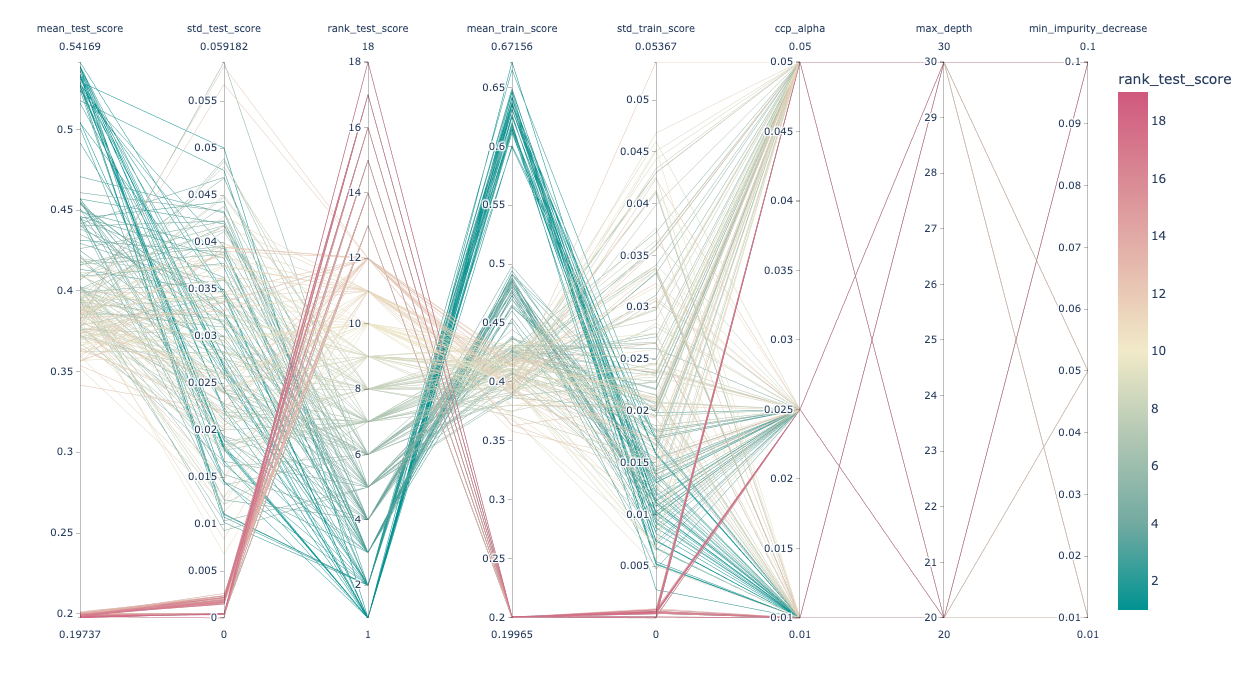

In [53]:
import plotly.express as px
import plotly

gs_data = hyperparam_results.drop(columns=[
        'index',
        'split0_test_score',
        'split1_test_score',
        'split2_test_score',
        'split3_test_score',
        'split4_test_score',
        'split0_train_score',
        'split1_train_score',
        'split2_train_score',
        'split3_train_score',
        'split4_train_score',
        'mean_fit_time',
        'std_fit_time',
        'mean_score_time',
        'std_score_time'
    ])

fig = px.parallel_coordinates(
    gs_data, 
    color="rank_test_score",
    labels={
        c: c.split('__')[-1] for c in gs_data.columns  
    },
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=10,
    height=700
)
fig.show()

In [21]:
scores_df.sort_values(['orig_test_data__orig_model__accuracy'])

KeyError: 'orig_test_data__orig_model__accuracy'